#### Loading Packages

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Functions for Prepping Data

In [33]:
def clean_data (data):
  data = data.drop('Cabin', axis=1)
  data = data.dropna()
  data['Fare'] = min_max_normalize(data['Fare'])
  data['Age'] = min_max_normalize(data['Age'])
  return data

def X_data (data):
  # data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
  # columns_select = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
  columns_select = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
  X = data[columns_select]
  X = X.dropna()
  # y = data['Survived']
  # X = data.drop('Survived', axis=1)
  X = pd.get_dummies(X, columns=['Sex', 'Embarked'], dtype=int, drop_first=True)
  return X

def y_data (data):
  y = data['Survived']
  return y

def min_max_normalize (column):
  min_val = column.min()
  max_val = column.max()
  normalized_col = (column - min_val) / (max_val - min_val)
  return normalized_col

def split_data (X, y, train_size):
  totalRows = X.shape[0]
  # splitPoint = int(totalRows * (1 - val_size))
  splitPoint = int(totalRows * train_size)
  X_train = X[:splitPoint]
  y_train = y[:splitPoint]
  X_val = X[splitPoint:]
  y_val = y[splitPoint:]
  return X_train, y_train, X_val, y_val


#### Read in & Clean Data
- will need to remove cabin and age columns
- some cells in embarked are null so won't need to remove all but can just remove those rows

In [30]:
training_data = pd.read_csv("./titanic-data/train.csv")
training_data = clean_data(training_data)

#### Feature Scaling
- go back and implement own one hot encoding function

In [35]:
X_sample = X_data(training_data)
y_sample = y_data(training_data)
X_train, y_train, X_val, y_val = split_data(X_sample, y_sample, 0.2)

# Sex_female and Embarked_C not included due to drop_first being set to True
print(f"Training data after one-hot encoding and min-max normalizing Age and Fare column:\n\n{X_train.head()}")

     Pclass       Age  SibSp  Parch      Fare  Sex_male  Embarked_Q  \
172       3  0.007288      1      1  0.021731         0           0   
173       3  0.258608      0      0  0.015469         1           0   
174       1  0.698417      0      0  0.059914         1           0   
175       3  0.220910      1      1  0.015330         1           0   
177       1  0.623021      0      0  0.056043         0           0   

     Embarked_S  
172           1  
173           1  
174           0  
175           1  
177           0  
     Pclass       Age  SibSp  Parch      Fare  Sex_male  Embarked_Q  \
178       2  0.371701      0      0  0.025374         1           0   
179       3  0.447097      0      0  0.000000         1           0   
182       3  0.107816      4      2  0.061264         1           0   
183       2  0.007288      2      1  0.076123         1           0   
184       3  0.044986      0      2  0.042990         0           0   

     Embarked_S  
178           1  
17

#### Functions for Logistic Regression

In [22]:
def sigmoid(z):
  #   returns sigmoid = 1/(1 + e^-z)
  #   -> handles vectors/matrices
  sigmoid = 1 / (1 + np.exp(-z))
  return sigmoid


def initialize_params(m_features, seed=42):
  #   returns vector (w) of size (m x 1) features with small random numbers, and the scalar b initialized to 0
  #   -> b = 0
  #   call this from one-hot encoding or create another section after one-hot encoding to do this
  #   - plug our samples into this function to get y_hat values
  # (0, 0.01) represents a gaussian distribution with mean 0 and std 0.01
  # -> might need to be adjusted late for model accuracy
  w = np.random.default_rng(seed).normal(0, 0.01, size=(m_features, 1))
  b = 0
  return w, b


def forward(X, w, b):
  #   returns
  #     z = X * w + b
  #     y_hat (pred) = sigmoid(z)
  X = X.to_numpy()
  z = np.dot(X, w) + b
  y_hat = sigmoid(z)
  return y_hat, z


def compute_cost(y, y_hat, eps=1e-12):
  #   -> computes binary cross-entropy cost w/ optional L2 penalty
  #   - check with notes:
  #     -> cost = -1/n * sum(y_i * log(y_hat_i) + (1 - y_i) * log(1 - y_hat_i))
  #     -> cost += reg_lambda / 2 * sum(w^2)
  n = y.shape[0]
  y = y.to_numpy()
  y = y.reshape(n, 1)
  y_hat = np.clip(y_hat, eps, 1 - eps)
  cost = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
  return cost


def compute_gradients(X, y, y_hat, w, reg_lambda=0.0):
  #   - dw = (1/n) * X * (y_hat - y) + (reg_lambda / n) * w
  #   - db = (1/n) * sum(y_hat_i - y_i) -> find the mean difference between y_hat (pred) and y (target)
  X = X.to_numpy()
  n = X.shape[0]  # represents num of features
  y = y.to_numpy()
  y = y.reshape(n, 1)
  pred_difference = y_hat - y
  dw = (1 / n) * np.dot(X.T, pred_difference) + (reg_lambda / n) * w
  db = (1 / n) * (y_hat - y).sum()  # .sum() allows us to take a sum of differences between prediction and target
  return dw, db


def update_params(w, b, dw, db, lr):
  #   Gradient step -> w: = w - (lr * dw)
  #                 -> b: = b - (lr * db)
  w = w - (lr * dw)
  b = b - (lr * db)
  return w, b


def train(X, y, lr, n_epochs, reg_lambda=0.0, X_val=None, y_val=None):
  #   I. training loop
  #       1.) forward pass
  #       2.) compute cost
  #       3.) compute gradients
  #       4.) update parameters
  #            -> track expected loss for each iteration. if X_val and y_val are provided, it will also track validation loss
  features = X.shape[1]
  w, b = initialize_params(features, seed=42)
  cost_history = []

  for epoch in range(n_epochs):
    y_hat, z = forward(X, w, b)
    cost = compute_cost(y, y_hat)
    cost_history.append(cost)
    dw, db = compute_gradients(X, y, y_hat, w, reg_lambda)
    w, b = update_params(w, b, dw, db, lr)

  #   II. Returns the trained parameters 'w' and 'b' and history of the cost for training and validation sets
  return w, b, cost_history


def predict_proba(X, w, b):
  X = X.to_numpy()
  z = np.dot(X, w) + b
  y_hat = sigmoid(z)
  return y_hat

#### Training Model with Self-Made Functions

In [23]:
learning_rate = 0.01
n_epochs = 10000
valid_params, bias, cost_history = train(X_train, y_train, learning_rate, n_epochs, reg_lambda=0.0, X_val=None, y_val=None)
# print(type(cost_history))

#### Plotting Cost History

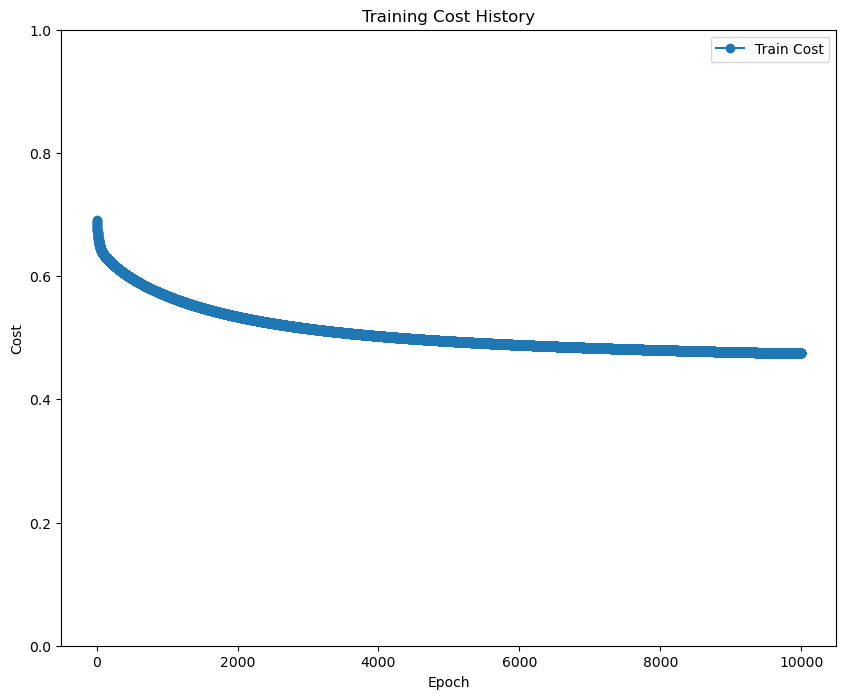

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(range(n_epochs), cost_history, marker='o', linewidth=1.5, label='Train Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.ylim(0, 1)
plt.title('Training Cost History')
plt.legend()
plt.show()

#### Testing Accuracy of Model

In [39]:
##########################################################################################
y_hat = predict_proba(X_val, valid_params, bias)
test_data = pd.read_csv("./titanic-data/test.csv")
# X_test, y_test = clean_data(test_data)
np.set_printoptions(suppress=True, precision=8)
print(f"First 5 results of the survivor probabilty prediction calculation:\n{y_hat[:5]}")
y_true = np.asarray(y_val).astype(int)
y_hat = y_hat.reshape(-1)

# Changes the y_hat to binary format
for i, y in enumerate(y_hat):
  if y >= 0.5: y_hat[i] = 1 # did survive
  elif y < 0.5: y_hat[i] = 0 # did not survive

accuracy = (y_hat == y_val).mean()
############################################################################################
# Design a confusion matrix to evaluate the accuracy of the model
print(f"Accuracy of model: {accuracy:.2f}")

First 5 results of the survivor probabilty prediction calculation:
[[0.23849415]
 [0.13978628]
 [0.09632063]
 [0.20804902]
 [0.62500227]]
Accuracy of model: 0.78


### Sci-kit Learn Model

#### Import Scikit-learn modules

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import log_loss
import joblib

#### Logistic Regression with Sklearn

In [27]:
model = LogisticRegression(max_iter=10000, random_state=0)
model.fit(X_train, y_true)
y_pred = model.predict(X_train)

print(f"Logistic Regression Accuracy:\n{accuracy_score(y_true, y_pred):.2f}\n")
print(f"Classification Report:\n{classification_report(y_true, y_pred)}\n")
print(f"Logistic Regression Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}\n")

joblib.dump(model, "titanic_survivor_pred.pkl")

Logistic Regression Accuracy:
0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       424
           1       0.77      0.71      0.74       288

    accuracy                           0.80       712
   macro avg       0.79      0.79      0.79       712
weighted avg       0.80      0.80      0.80       712


Logistic Regression Confusion Matrix:
[[364  60]
 [ 83 205]]



['titanic_survivor_pred.pkl']

#### Testing Model

In [28]:
test_data = pd.read_csv("./titanic-data/test.csv")
test_data_clean = clean_data(test_data)
test_data_id = test_data_clean['PassengerId'].copy()
X_test = X_data(test_data_clean)

loaded_model = joblib.load("titanic_survivor_pred.pkl")
survivor_pred = model.predict(X_test)
survivor_prob = model.predict_proba(X_test)[:, 1]

# print(test_data_id.shape)
# print(survivor_pred.shape)
# print(survivor_prob.shape)

results = pd.DataFrame ( {
  'PassengerId': test_data_id,
  'Survived': survivor_pred,
  'Survival Probability': survivor_prob
} )
print(results.head())

   PassengerId  Survived  Survival Probability
0          892         0              0.070371
1          893         0              0.359385
2          894         0              0.085839
3          895         0              0.106743
4          896         1              0.547768
